# Notebook 5: Perfis de Consumo dos Clientes

## Curso ABAR - Medições Inteligentes e Gestão Integrada

### Objetivo
Analisar os perfis de consumo horário dos 7 clientes do distrito, suas condições operacionais e participação relativa.

### Conceitos-chave
- Cada ponto de medição (cliente) possui um **medidor** que registra volume, pressão e temperatura
- As **condições operacionais** (faixas de vazão, pressão e temperatura) devem estar compatíveis com as especificações do medidor
- O **perfil de consumo** revela o padrão de utilização do gás (contínuo, variável, cíclico)
- O **fator de carga** (média/máximo) indica quão constante é o consumo

In [1]:
import sys
from pathlib import Path

# Configurar caminhos do projeto
PROJECT_ROOT = Path('.').resolve().parent if Path('.').resolve().name == 'notebooks' else Path('.').resolve()
sys.path.insert(0, str(PROJECT_ROOT / 'src'))
from config import DATA_DIR, GRAFICOS_DIR, EXCEL_DEFAULT

EXCEL_PATH = DATA_DIR / EXCEL_DEFAULT
GRAFICOS_DIR.mkdir(parents=True, exist_ok=True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

## 1. Carregamento dos Dados de Todos os Clientes

In [2]:
# Mapeamento de clientes
CLIENTES = {
    'Cliente #1': 'Empresa A',
    'Cliente #2': 'Empresa B',
    'Cliente #3': 'Empresa C',
    'Cliente #4': 'Empresa D',
    'Cliente #5': 'Empresa E',
    'Cliente #6': 'Empresa F',
    'Cliente #7': 'Empresa G'
}

# Volumes de referência da Planilha1 (para clientes sem dados horários)
VOLUMES_REFERENCIA = {
    'Empresa D': 88184  # Nm³ total no período
}

# Carregar todos os clientes
dados_clientes = {}

for aba, nome in CLIENTES.items():
    df = pd.read_excel(EXCEL_PATH, sheet_name=aba, header=2, usecols='B:E')
    df.columns = ['Data', 'Volume_Nm3h', 'Pressao_bara', 'Temperatura_C']
    df['Data'] = pd.to_datetime(df['Data'], errors='coerce')
    
    # Converter numéricas
    for col in ['Volume_Nm3h', 'Pressao_bara', 'Temperatura_C']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    df = df.dropna(subset=['Data']).reset_index(drop=True)
    
    sem_dados = len(df) == 0 or df['Volume_Nm3h'].dropna().empty
    dados_clientes[aba] = {'nome': nome, 'dados': df, 'sem_dados': sem_dados}
    
    if sem_dados:
        vol_ref = VOLUMES_REFERENCIA.get(nome, 0)
        print(f'{nome:.<30} SEM DADOS HORÁRIOS | '
              f'Volume de referência (Planilha1): {vol_ref:,.0f} Nm³')
    else:
        print(f'{nome:.<30} {len(df):>6} registros | '
              f'Vol: {df["Volume_Nm3h"].mean():>10,.0f} Nm³/h (média)')

Empresa A...................   4344 registros | Vol:     23,965 Nm³/h (média)
Empresa B...........   4344 registros | Vol:     10,052 Nm³/h (média)


Empresa C.............   4367 registros | Vol:      1,567 Nm³/h (média)


Empresa D....................   4344 registros | Vol:         47 Nm³/h (média)


Empresa E..........   4344 registros | Vol:      2,345 Nm³/h (média)


Empresa F...................   4344 registros | Vol:      1,372 Nm³/h (média)


Empresa G..................   4344 registros | Vol:      2,321 Nm³/h (média)


## 2. Tabela Resumo - Condições Operacionais

In [3]:
# Construir tabela resumo
resumo = []

for aba, info in dados_clientes.items():
    df = info['dados']
    nome = info['nome']
    
    if info['sem_dados']:
        vol_ref = VOLUMES_REFERENCIA.get(nome, 0)
        resumo.append({
            'Cliente': nome + ' *',
            'Vol Mín (Nm³/h)': np.nan,
            'Vol Méd (Nm³/h)': np.nan,
            'Vol Máx (Nm³/h)': np.nan,
            'Vol Total (Mm³)': vol_ref / 1e6,
            'Press Méd (bara)': np.nan,
            'Press Máx (bara)': np.nan,
            'Temp Méd (°C)': np.nan,
            'Temp Máx (°C)': np.nan,
            'Fator Carga': np.nan
        })
        continue
    
    vol = df['Volume_Nm3h']
    pres = df['Pressao_bara']
    temp = df['Temperatura_C']
    
    resumo.append({
        'Cliente': nome,
        'Vol Mín (Nm³/h)': vol.min(),
        'Vol Méd (Nm³/h)': vol.mean(),
        'Vol Máx (Nm³/h)': vol.max(),
        'Vol Total (Mm³)': vol.sum() / 1e6,
        'Press Méd (bara)': pres.mean(),
        'Press Máx (bara)': pres.max(),
        'Temp Méd (°C)': temp.mean(),
        'Temp Máx (°C)': temp.max(),
        'Fator Carga': vol.mean() / vol.max() if vol.max() > 0 else 0
    })

df_resumo = pd.DataFrame(resumo)
df_resumo = df_resumo.sort_values('Vol Total (Mm³)', ascending=False).reset_index(drop=True)
print('* = Volume de referência da Planilha1 (sem dados horários disponíveis)')
df_resumo

* = Volume de referência da Planilha1 (sem dados horários disponíveis)


,Cliente,Vol Mín (Nm³/h),Vol Méd (Nm³/h),Vol Máx (Nm³/h),Vol Total (Mm³),Press Méd (bara),Press Máx (bara),Temp Méd (°C),Temp Máx (°C),Fator Carga
0,Empresa A,1359.0,23965.136510,31245.0,104.104553,15.472541,17.68,23.489390,26.80,0.767007
1,Empresa B,178.0,10051.674724,17113.0,43.664475,15.957836,17.62,23.413527,29.38,0.587371
2,Empresa E,300.0,2344.531538,4244.0,10.184645,4.925134,5.08,16.698080,21.85,0.552434
3,Empresa G,418.0,2320.884899,7085.0,10.081924,7.335753,10.67,18.522756,24.92,0.327577
4,Empresa C,0.0,1566.692695,4959.0,6.841747,5.150195,5.68,17.836618,25.02,0.315929
5,Empresa F,0.0,1371.526703,3509.0,5.957912,7.545279,8.03,20.490311,35.95,0.390860
6,Empresa D,0.0,47.385277,187.0,0.088184,18.571698,18.87,23.639398,37.09,0.253397


## 3. Gráficos

### 3.1 Séries Temporais de Volume por Cliente

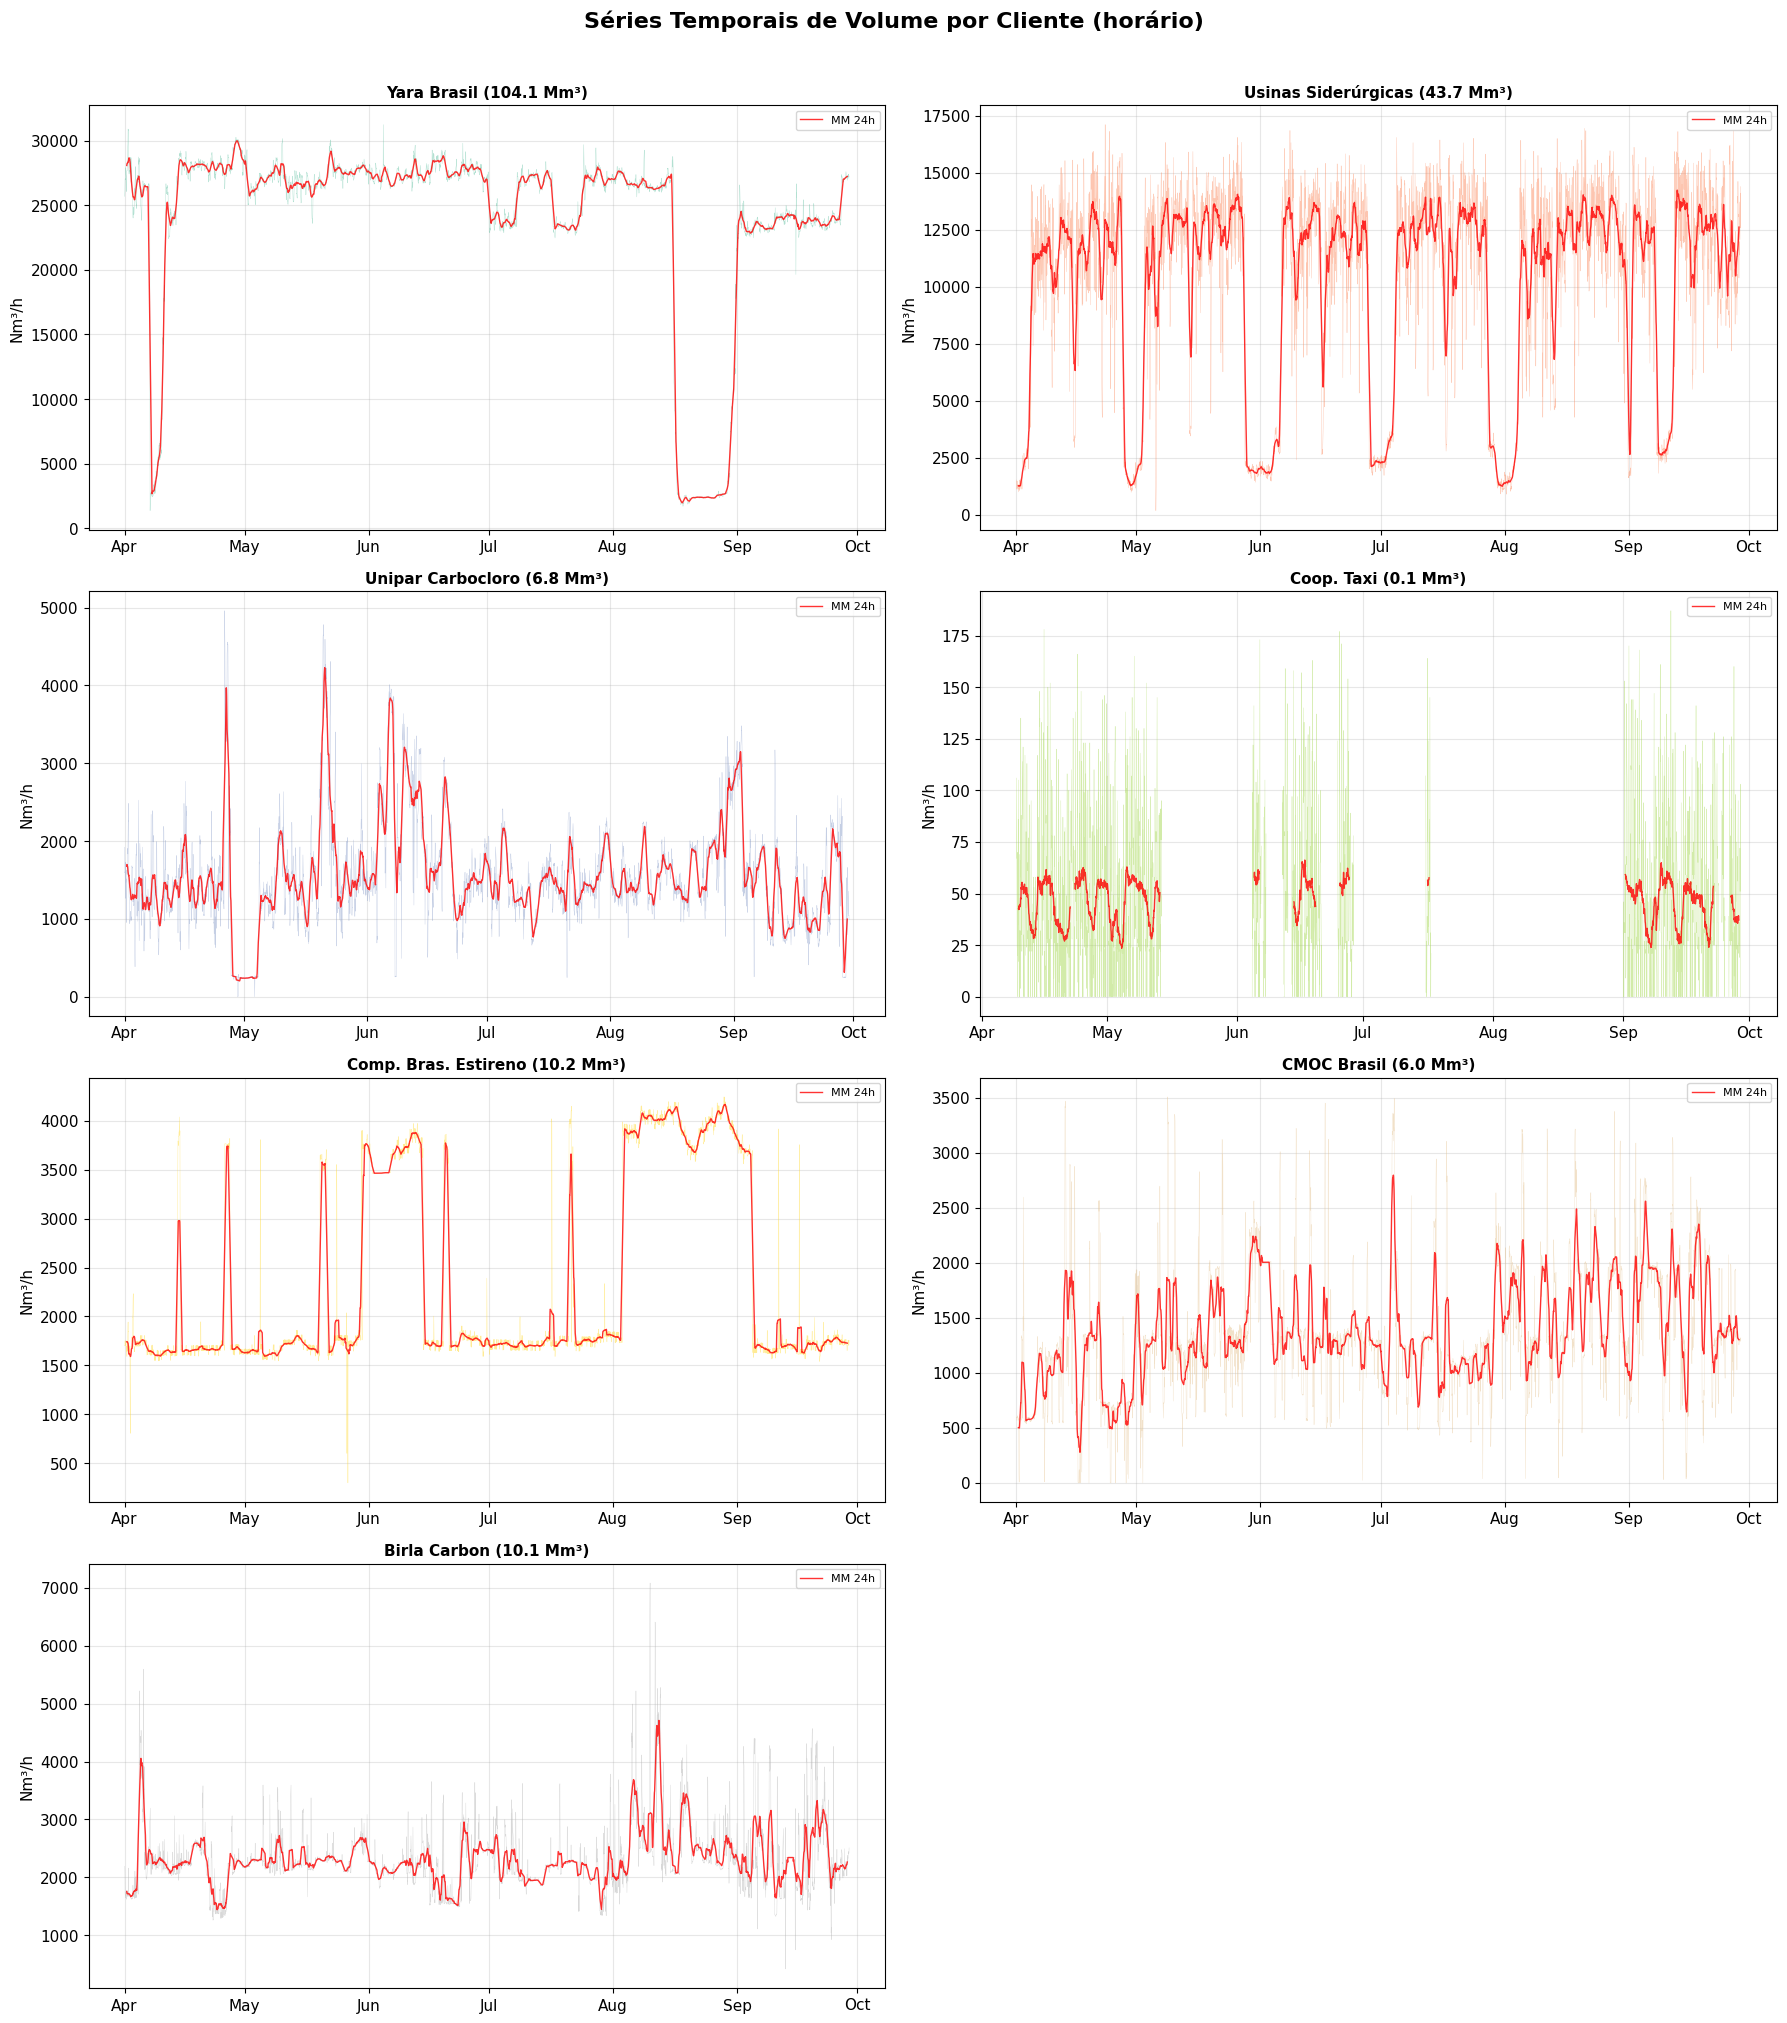

In [4]:
fig, axes = plt.subplots(4, 2, figsize=(18, 20))
axes = axes.flatten()

cores = plt.cm.Set2(np.linspace(0, 1, 7))

plot_idx = 0
for aba, info in dados_clientes.items():
    ax = axes[plot_idx]
    
    if info['sem_dados']:
        vol_ref = VOLUMES_REFERENCIA.get(info['nome'], 0)
        ax.text(0.5, 0.5, f'{info["nome"]}\nSem dados horários\nVol. referência: {vol_ref:,.0f} Nm³',
                ha='center', va='center', fontsize=12, transform=ax.transAxes,
                bbox=dict(boxstyle='round', facecolor='lightyellow'))
        ax.set_title(f'{info["nome"]} (sem dados)', fontweight='bold', fontsize=11)
        plot_idx += 1
        continue
    
    df = info['dados']
    nome = info['nome']
    
    ax.plot(df['Data'], df['Volume_Nm3h'], color=cores[plot_idx], alpha=0.5, linewidth=0.3)
    
    # Média móvel diária (24h)
    mm = df['Volume_Nm3h'].rolling(window=24, center=True).mean()
    ax.plot(df['Data'], mm, color='red', alpha=0.8, linewidth=1, label='MM 24h')
    
    vol_total = df['Volume_Nm3h'].sum() / 1e6
    ax.set_title(f'{nome} ({vol_total:.1f} Mm³)', fontweight='bold', fontsize=11)
    ax.set_ylabel('Nm³/h')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plot_idx += 1

# Esconder o último subplot vazio
axes[-1].set_visible(False)

fig.suptitle('Séries Temporais de Volume por Cliente (horário)', 
             fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig(str(GRAFICOS_DIR / 'clientes_serie.png'), dpi=150, bbox_inches='tight')
plt.show()

### 3.2 Perfil Horário Médio (média por hora do dia)

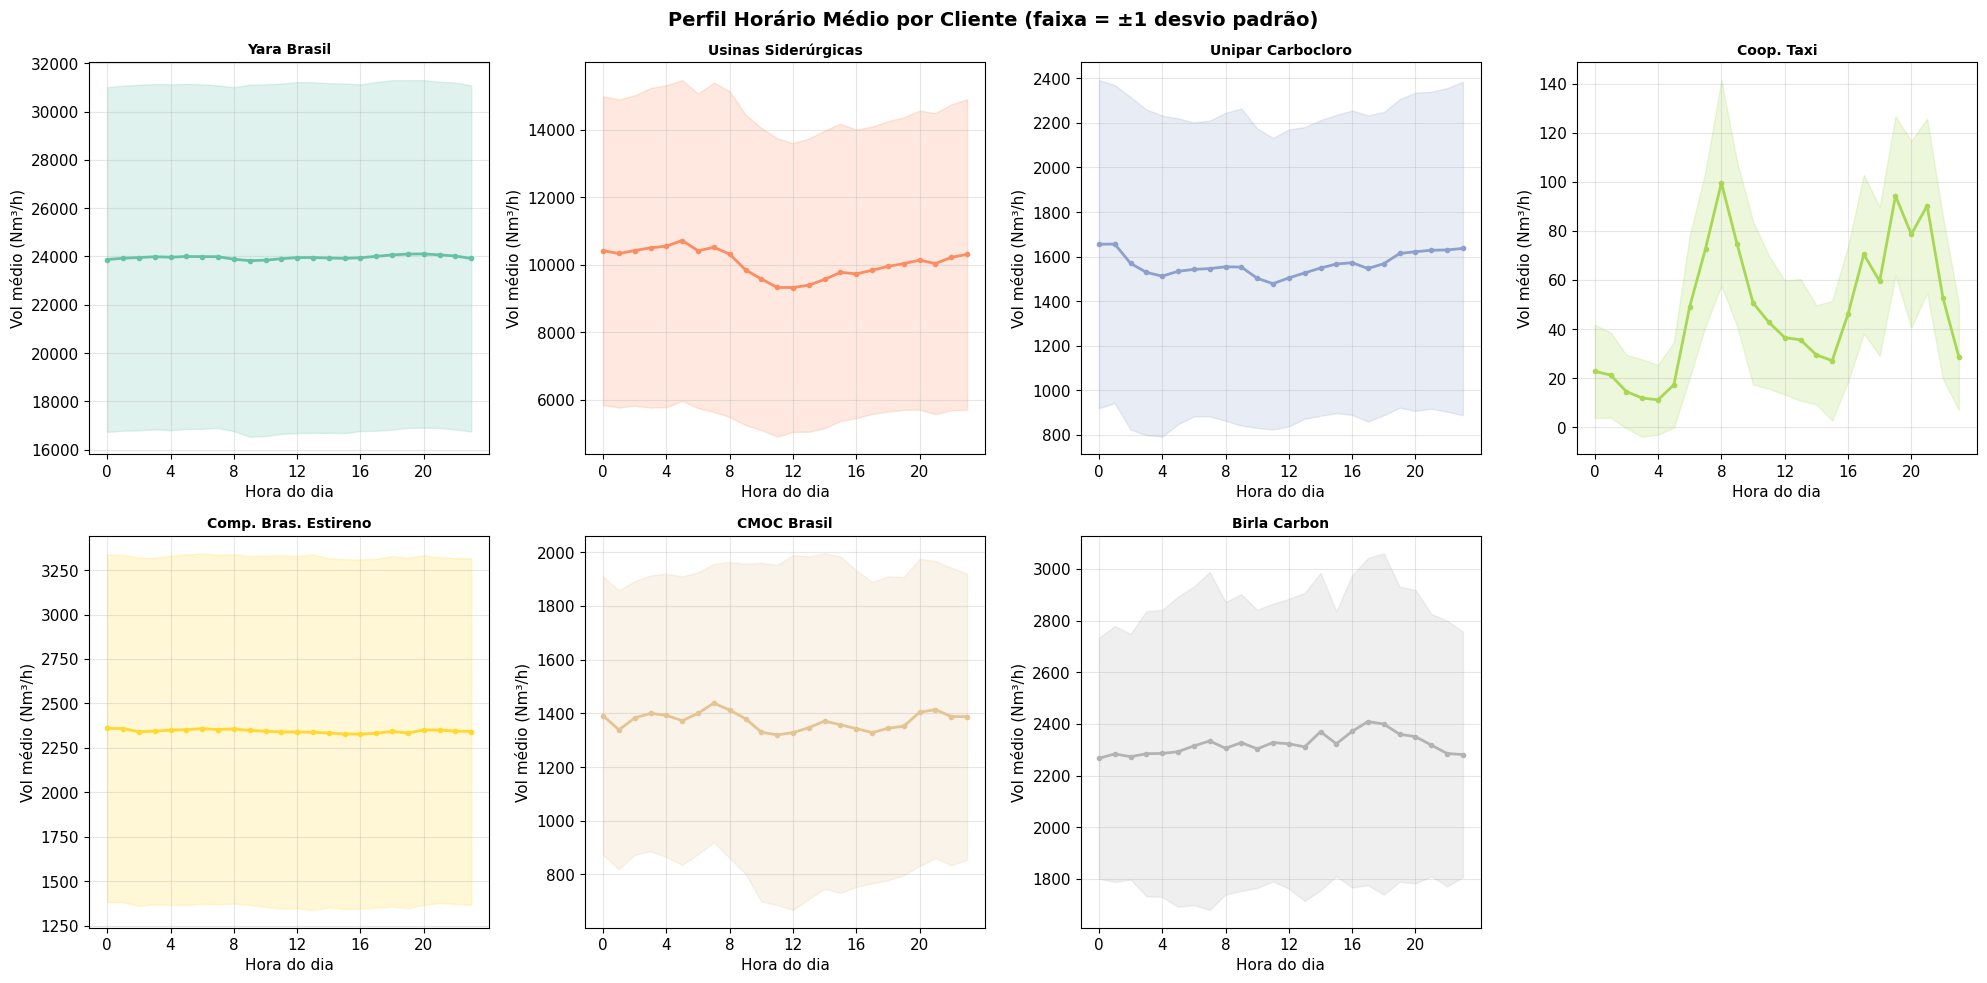

In [5]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

plot_idx = 0
for aba, info in dados_clientes.items():
    ax = axes[plot_idx]
    
    if info['sem_dados']:
        ax.text(0.5, 0.5, 'Sem dados', ha='center', va='center', fontsize=12,
                transform=ax.transAxes)
        ax.set_title(info['nome'] + ' *', fontweight='bold', fontsize=10)
        plot_idx += 1
        continue
    
    df = info['dados'].copy()
    nome = info['nome']
    
    df['Hora'] = df['Data'].dt.hour
    perfil = df.groupby('Hora')['Volume_Nm3h'].agg(['mean', 'std'])
    
    ax.fill_between(perfil.index, 
                    perfil['mean'] - perfil['std'], 
                    perfil['mean'] + perfil['std'], 
                    alpha=0.2, color=cores[plot_idx])
    ax.plot(perfil.index, perfil['mean'], color=cores[plot_idx], linewidth=2, marker='o', markersize=3)
    
    ax.set_title(nome, fontweight='bold', fontsize=10)
    ax.set_xlabel('Hora do dia')
    ax.set_ylabel('Vol médio (Nm³/h)')
    ax.set_xticks(range(0, 24, 4))
    ax.grid(True, alpha=0.3)
    plot_idx += 1

axes[-1].set_visible(False)

fig.suptitle('Perfil Horário Médio por Cliente (faixa = ±1 desvio padrão)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(str(GRAFICOS_DIR / 'clientes_perfil_horario.png'), dpi=150, bbox_inches='tight')
plt.show()

### 3.3 Heatmap - Volume por Hora × Dia (Empresa A - Maior Consumidor)

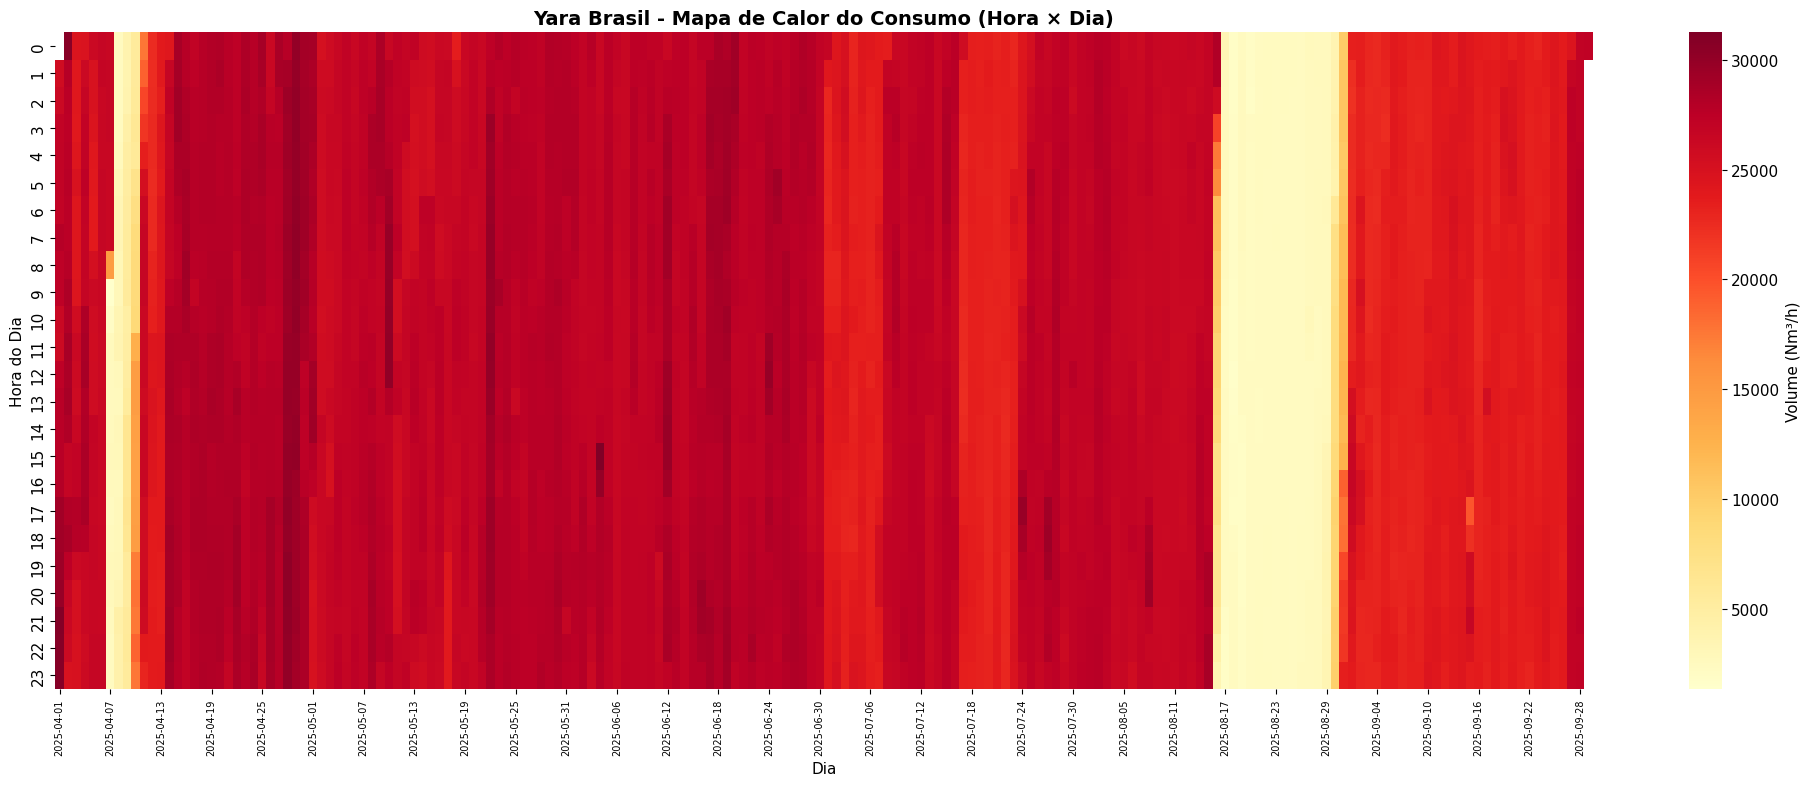

In [6]:
# Heatmap para o maior cliente (Empresa A)
df_yara = dados_clientes['Cliente #1']['dados'].copy()
df_yara['Dia'] = df_yara['Data'].dt.date
df_yara['Hora'] = df_yara['Data'].dt.hour

# Pivot table
pivot = df_yara.pivot_table(values='Volume_Nm3h', index='Hora', columns='Dia', aggfunc='mean')

fig, ax = plt.subplots(figsize=(20, 8))

# Mostrar a cada N dias para legibilidade
step = max(1, len(pivot.columns) // 30)
sns.heatmap(pivot, ax=ax, cmap='YlOrRd', 
            xticklabels=step,
            yticklabels=1,
            cbar_kws={'label': 'Volume (Nm³/h)'})

ax.set_title('Empresa A - Mapa de Calor do Consumo (Hora × Dia)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Dia')
ax.set_ylabel('Hora do Dia')
plt.xticks(rotation=90, fontsize=7)
plt.tight_layout()
plt.savefig(str(GRAFICOS_DIR / 'clientes_heatmap.png'), dpi=150, bbox_inches='tight')
plt.show()

### 3.4 Condições Operacionais - Pressão e Temperatura

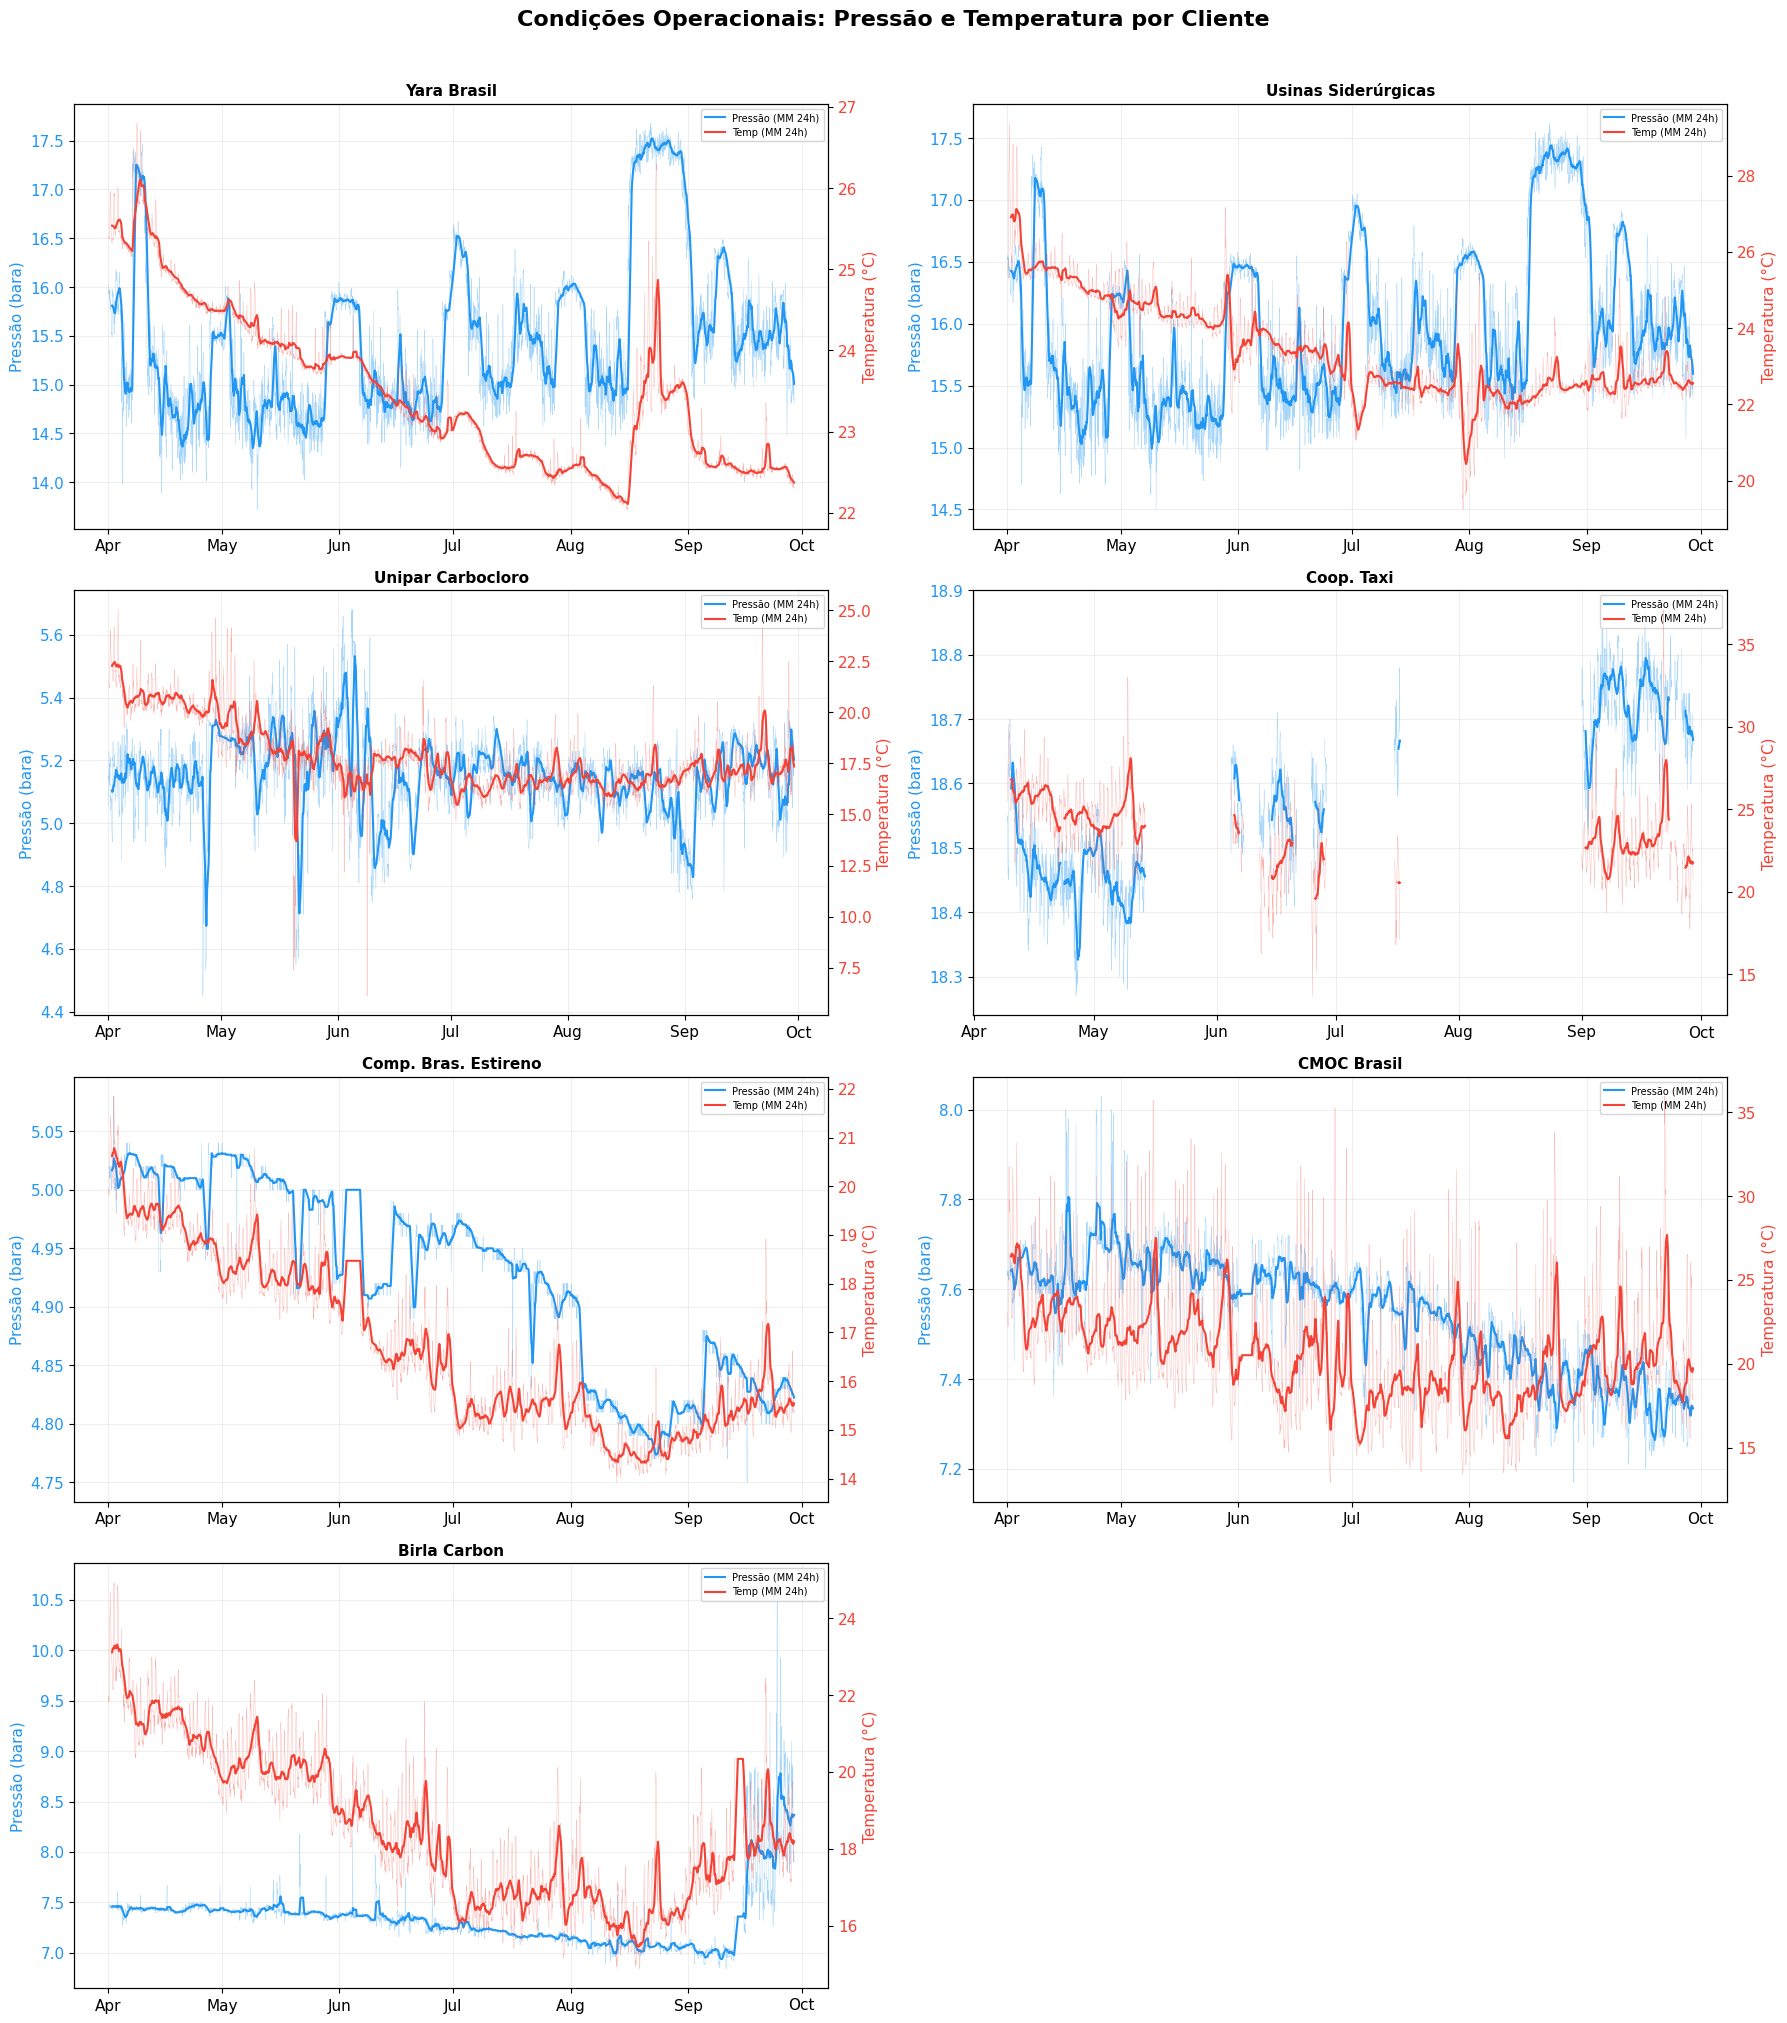

In [7]:
fig, axes = plt.subplots(4, 2, figsize=(18, 20))
axes = axes.flatten()

plot_idx = 0
for aba, info in dados_clientes.items():
    ax = axes[plot_idx]
    
    if info['sem_dados']:
        ax.text(0.5, 0.5, 'Sem dados', ha='center', va='center', fontsize=12,
                transform=ax.transAxes)
        ax.set_title(info['nome'] + ' *', fontweight='bold', fontsize=10)
        plot_idx += 1
        continue
    
    df = info['dados']
    nome = info['nome']
    
    # Pressão no eixo esquerdo
    color1 = '#2196F3'
    ax.plot(df['Data'], df['Pressao_bara'], color=color1, alpha=0.4, linewidth=0.3)
    mm_p = df['Pressao_bara'].rolling(window=24).mean()
    ax.plot(df['Data'], mm_p, color=color1, linewidth=1.5, label='Pressão (MM 24h)')
    ax.set_ylabel('Pressão (bara)', color=color1)
    ax.tick_params(axis='y', labelcolor=color1)
    
    # Temperatura no eixo direito
    ax2 = ax.twinx()
    color2 = '#F44336'
    ax2.plot(df['Data'], df['Temperatura_C'], color=color2, alpha=0.4, linewidth=0.3)
    mm_t = df['Temperatura_C'].rolling(window=24).mean()
    ax2.plot(df['Data'], mm_t, color=color2, linewidth=1.5, label='Temp (MM 24h)')
    ax2.set_ylabel('Temperatura (°C)', color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)
    
    ax.set_title(nome, fontweight='bold', fontsize=11)
    ax.grid(True, alpha=0.2)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    
    # Legenda combinada
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, fontsize=7, loc='upper right')
    plot_idx += 1

axes[-1].set_visible(False)

fig.suptitle('Condições Operacionais: Pressão e Temperatura por Cliente', 
             fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig(str(GRAFICOS_DIR / 'clientes_pressao_temp.png'), dpi=150, bbox_inches='tight')
plt.show()

### 3.5 Volume Total por Cliente - Participação no Distrito

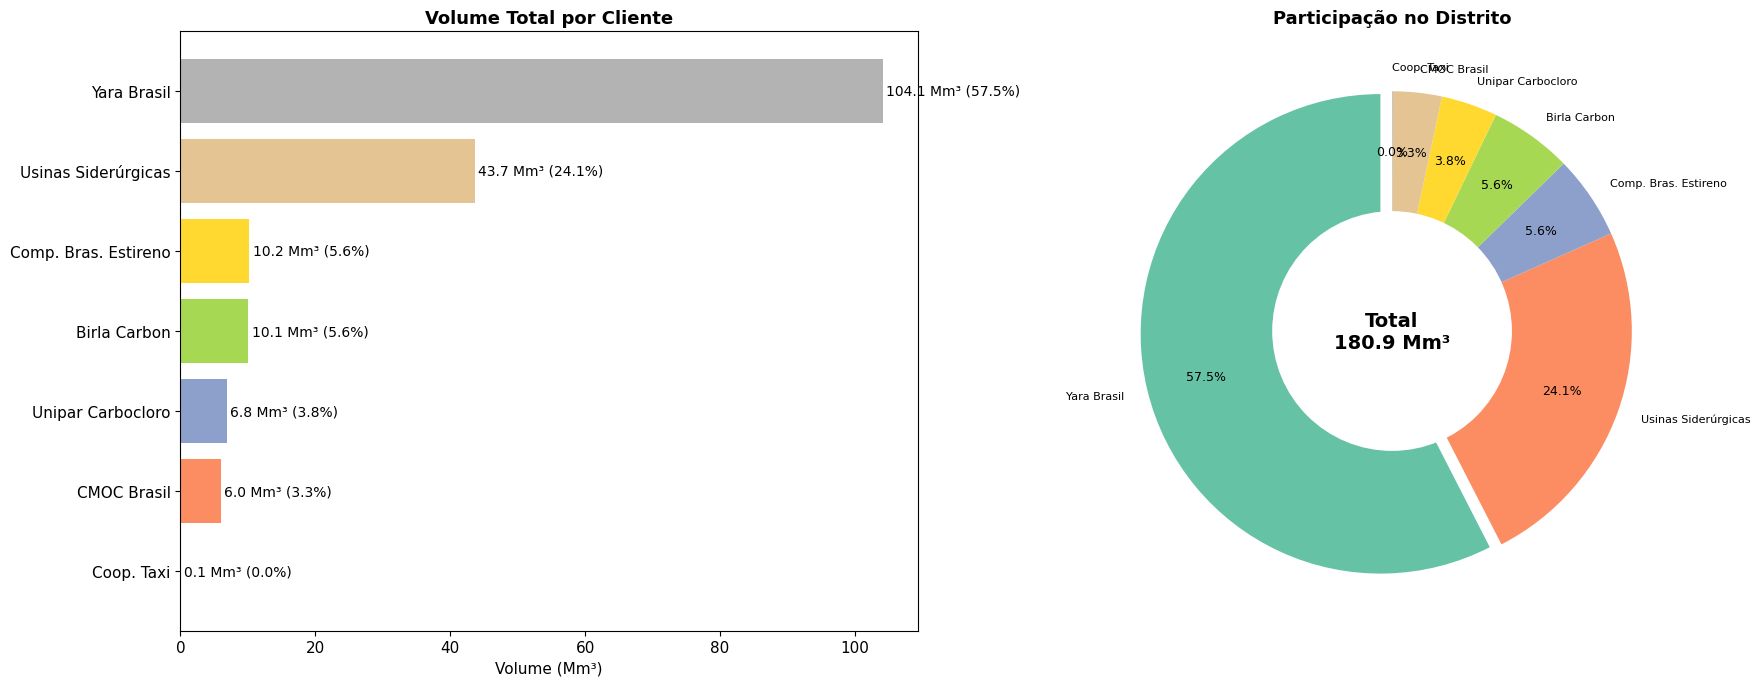

In [8]:
# Preparar dados (usando volume de referência para clientes sem dados)
vol_total = {}
for aba, info in dados_clientes.items():
    nome = info['nome']
    if info['sem_dados']:
        vol_total[nome] = VOLUMES_REFERENCIA.get(nome, 0) / 1e6
    else:
        vol_total[nome] = info['dados']['Volume_Nm3h'].sum() / 1e6

nomes = list(vol_total.keys())
volumes = list(vol_total.values())
total = sum(volumes)
pcts = [v / total * 100 for v in volumes]

# Ordenar por volume
ordem = np.argsort(volumes)[::-1]
nomes_ord = [nomes[i] for i in ordem]
volumes_ord = [volumes[i] for i in ordem]
pcts_ord = [pcts[i] for i in ordem]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Gráfico de barras
cores_bar = plt.cm.Set2(np.linspace(0, 1, len(nomes_ord)))
bars = ax1.barh(nomes_ord[::-1], volumes_ord[::-1], color=cores_bar)
for bar, vol, pct in zip(bars, volumes_ord[::-1], pcts_ord[::-1]):
    ax1.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
             f'{vol:.1f} Mm³ ({pct:.1f}%)', va='center', fontsize=10)
ax1.set_title('Volume Total por Cliente', fontweight='bold', fontsize=13)
ax1.set_xlabel('Volume (Mm³)')

# Gráfico de pizza/donut
explode = [0.05 if v == max(volumes_ord) else 0 for v in volumes_ord]
wedges, texts, autotexts = ax2.pie(
    volumes_ord, labels=nomes_ord, autopct='%1.1f%%',
    colors=plt.cm.Set2(np.linspace(0, 1, len(nomes_ord))),
    explode=explode, pctdistance=0.75, startangle=90
)

# Donut
centro = plt.Circle((0, 0), 0.5, fc='white')
ax2.add_patch(centro)
ax2.text(0, 0, f'Total\n{total:.1f} Mm³', ha='center', va='center', 
         fontsize=14, fontweight='bold')
ax2.set_title('Participação no Distrito', fontweight='bold', fontsize=13)

for text in autotexts:
    text.set_fontsize(9)
for text in texts:
    text.set_fontsize(8)

plt.tight_layout()
plt.savefig(str(GRAFICOS_DIR / 'clientes_participacao.png'), dpi=150, bbox_inches='tight')
plt.show()

### 3.6 Boxplots Comparativos de Volume

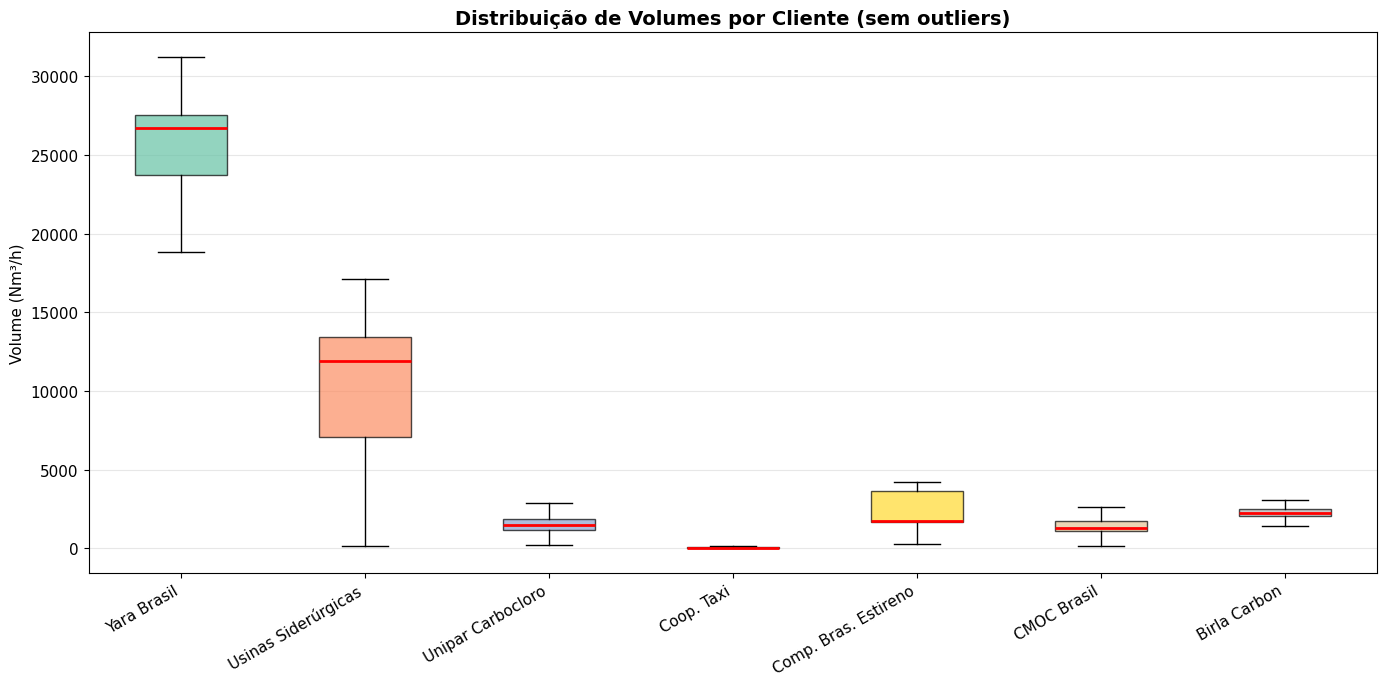


Nota: Empresa D excluída do boxplot por não possuir dados horários.


In [9]:
fig, ax = plt.subplots(figsize=(14, 7))

# Preparar dados para boxplot (excluir clientes sem dados horários)
box_data = []
box_labels = []
box_cores = []
color_idx = 0
for aba, info in dados_clientes.items():
    if not info['sem_dados']:
        box_data.append(info['dados']['Volume_Nm3h'].dropna().values)
        box_labels.append(info['nome'])
        box_cores.append(cores[color_idx])
    color_idx += 1

bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True, vert=True,
                showfliers=False,  # Esconder outliers para clareza
                boxprops=dict(alpha=0.7),
                medianprops=dict(color='red', linewidth=2))

# Colorir caixas
for patch, color in zip(bp['boxes'], box_cores):
    patch.set_facecolor(color)

ax.set_title('Distribuição de Volumes por Cliente (sem outliers)', fontsize=14, fontweight='bold')
ax.set_ylabel('Volume (Nm³/h)')
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.savefig(str(GRAFICOS_DIR / 'clientes_boxplot.png'), dpi=150, bbox_inches='tight')
plt.show()

print('\nNota: Empresa D excluída do boxplot por não possuir dados horários.')

## 4. Análise do Fator de Carga

In [10]:
print('=== Fator de Carga por Cliente ===')
print('(Fator de Carga = Média / Máximo -> quanto mais próximo de 1, mais constante o consumo)\n')

for _, row in df_resumo.iterrows():
    fc = row['Fator Carga']
    if pd.isna(fc):
        print(f'{row["Cliente"]:<25} FC = N/D   (sem dados horários)')
    else:
        barra = '#' * int(fc * 50)
        print(f'{row["Cliente"]:<25} FC = {fc:.3f} |{barra}')

=== Fator de Carga por Cliente ===
(Fator de Carga = Média / Máximo -> quanto mais próximo de 1, mais constante o consumo)

Empresa A               FC = 0.767 |######################################
Empresa B       FC = 0.587 |#############################
Empresa E      FC = 0.552 |###########################
Empresa G              FC = 0.328 |################
Empresa C         FC = 0.316 |###############
Empresa F               FC = 0.391 |###################
Empresa D                FC = 0.253 |############


## 5. Conclusões

### Observações:
- **Empresa A** é o maior consumidor (57,5% do distrito), com consumo relativamente estável
- **Empresa B** é o segundo (24,1%), com mais variabilidade
- **Empresa D** é o menor (0,05%), praticamente insignificante no balanço
- Clientes industriais (#1, #2, #5) têm padrão de consumo mais constante
- O fator de carga indica a regularidade do consumo de cada cliente
- Condições de pressão e temperatura devem estar nas faixas do medidor instalado